In [1]:
import numpy as np
import matplotlib.pyplot as plt
from onix.units import ureg, Q_
from onix.analysis.fitter import Fitter

In [43]:
# Params
V_noise_density = 5e-8 * ureg.V / np.sqrt(1 * ureg.Hz)
V_freq = 100 * ureg.kHz # 10 us
V_signal = 0.9375 * ureg.V # From pd_model.ipynb assuming 500 uW to photodiode

optical_depth_max = 1.5 # max OD of crystal
fraction_light_in_sideband = 0.3 
fraction_pi_pulse = 0.8

N = 4 # Number of datapoints in the antihole
M = 20 # Number of offset measurements

rabi_freq = 2*np.pi*10e3 * ureg.Hz # Rabi frequency
sigma = 30e3 * ureg.Hz # Spread in 

In [44]:
# To get Vr at specified freq
def specified_val_gaussian(x):
    return np.exp(-(0 - x) ** 2 / (2 * sigma.magnitude **2))

# Fitting Gaussian
def Gaussian(x, a, mu, sig, c):
    return a * np.exp(-(x-mu)**2 / (2*sig**2)) + c

In [45]:
V_noise = (V_noise_density * np.sqrt(V_freq)).to("V")
SNR = V_signal/V_noise

Vc = V_signal
Va = Vc*(1-fraction_light_in_sideband) + Vc*fraction_light_in_sideband*np.exp(-optical_depth_max)
Va_error = Va/SNR/np.sqrt(N)

freqs = np.linspace(-75e3, 75e3, M)

diffs = []
diff_errors = []
SNRs = []

def diff_and_errors(freq):
    Vr = Va + (Vc-Va)*0.5*(rabi_freq/(2*np.log(2)*sigma))*fraction_pi_pulse*specified_val_gaussian(freq)
    Vr_error = Vr/SNR/np.sqrt(N)
    
    diff = abs(Va - Vr)
    diff_error = np.sqrt( Va_error ** 2 + Vr_error ** 2 )

    return diff, diff_error
    
for freq in freqs:    
    diff, diff_error = diff_and_errors(freq)
    diffs.append(diff.to("V").magnitude)
    diff_errors.append(diff_error.to("V").magnitude)
    SNRs.append((diff/diff_error).magnitude)

print(SNRs)
print(V_noise)
print(SNR)

[673.8539201696125, 1252.3693710913333, 2167.3072885038437, 3490.646937499265, 5231.31075141988, 7298.220980379083, 9489.40468120829, 11520.9629523604, 13089.427962482681, 13943.946446415774, 13943.946446415774, 13089.427962482681, 11520.9629523604, 9489.40468120829, 7298.220980379083, 5231.31075141988, 3490.646937499265, 2167.3072885038564, 1252.3693710913333, 673.8539201696125]
1.5811388300841894e-05 volt
59292.70612815712 dimensionless


In [46]:
sampled_diffs = []
for diff, diff_error in zip(diffs, diff_errors):
    sampled_diffs.append(np.random.normal(diff, diff_error, 1)[0])

fitter = Fitter(Gaussian)
fitter.set_data(freqs, sampled_diffs, diff_errors)
fitter.set_p0({"a" : 0.2, "mu" : 0, "sig" : sigma.magnitude, "c": 0})
fitter.fit()

a = fitter.results["a"]
mu = fitter.results["mu"]
sig = fitter.results["sig"]
c = fitter.results["c"]

delta_f = fitter.errors["mu"] * ureg.Hz
print(f"delta f = {delta_f}")

delta f = 1.1171380766185528 hertz


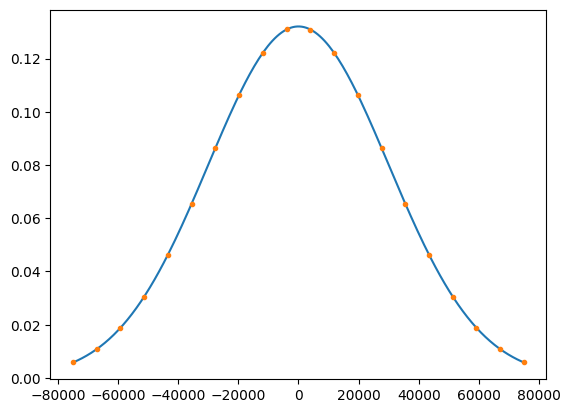

In [47]:
freqs_fit = np.linspace(-75e3, 75e3, 200)
plt.plot(freqs_fit, Gaussian(freqs_fit, a, mu, sig, c))
plt.plot(freqs, sampled_diffs, '.')
plt.show()

In [48]:
# Projecting HWHM error into the center frequency error
FWHM = 2*np.sqrt(2*np.log(2))*sigma
HWHM = (FWHM/2).magnitude
diff_HWHM, diff_error_HWHM = diff_and_errors(HWHM)
delta_f = diff_error_HWHM/diff_HWHM * HWHM/np.sqrt(M) * ureg.Hz
print(f"delta f = {delta_f}")

delta f = 1.0739607407207263 hertz


In [49]:
single_measurement_time = 100 * ureg.s
delta_f_0 = 1 * ureg.mHz

measurement_time = single_measurement_time * (delta_f/delta_f_0)**2

print(measurement_time.to("year"))

3.654877660561674 year
